# Guided Final Project



For your final project, you will be implementing a variational autoencoder (VAE) and applying it to neural data.



### Copying this Colab Notebook to your Google Drive

Since the course staff is the author of this notebook, you cannot make any lasting changes to it. You should make a copy of it to your Google Drive.

Alternatively, you may download a copy and work locally.

### Compute

You should not need to use the GPU for this problem. If you do choose to accelerate your training runs with the GPU, keep in mind that Google Colab will limit your GPU usage. You can change your runtime by going to **Runtime -> Change runtime type**.

If Google Colab restricts your access to a free GPU, you will regain access to the GPU after an indeterminate amount of time (anecdotally, anywhere from a few hours to a day). In the meantime, you can switch your runtime back to CPU.

### Code: Setup

We start by importing some packages that we'll need to complete this problem and some basic scaffolding.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import torch.distributions as dist
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_device():
    """
    Helper function to set the device. CUDA if available, else MPS if available (Apple Silicon,
    if you are working locally on a newer Apple device), CPU otherwise.

    Args:
        None.

    Returns:
        Device string ("cuda", "mps" or "cpu").
    """
    if torch.backends.cuda.is_built() and torch.cuda.is_available():
        device = "cuda"
        print("CUDA GPU enabled.")
    elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
        device = "mps"
        print("Apple Silicon GPU enabled.")
    else:
        device = "cpu"
        print("No GPU found. Running on CPU.")

    return device

We will be using the neural data from HW2, Question 4, where we consider the delayed reach task that we've discussed in depth now. To load the data, first download the ```data.zip``` file from Canvas (available under the "Final Project" module) and place into the "Files" tab on the left hand side of this Colab notebook. Then, run the following cell to load in the data.

*Note: Once your Colab runtime has disconnected (when you close out of the notebook or change your runtime type), you will have to reload the ```data.zip``` file into your new runtime. To avoid this, you can save the ```data.zip``` file to your Google Drive and mount your Google Drive to your Colab notebook, using the following two lines:*
```
from google.colab import drive
drive.mount('/content/drive')
```
*If you choose to mount your Google Drive, update the following cells and data paths to make sure you are loading in the correct files.*

In [3]:
train_data_loaded = np.load("data/ps2a_train.npy").astype("float32")
test_data_loaded = np.load("data/ps2a_test.npy").astype("float32")
num_class, num_train_trials, num_features = train_data_loaded.shape
_, num_test_trials, _ = test_data_loaded.shape

# reshape raw data into the format that we want
train_data = train_data_loaded.reshape((-1, num_features))
test_data = test_data_loaded.reshape((-1, num_features))
# include labels for each class
train_labels = np.repeat(np.arange(8), num_train_trials)
test_labels = np.repeat(np.arange(8), num_test_trials)

num_observations, _ = train_data.shape

Now, we define a simple dataset class to format the data to utilize the PyTorch library:

In [4]:
class SimpleDataset(Dataset):
    def __init__(self, data_bxd, labels, device='cpu'):
        super().__init__()
        self.device = device
        self.data_bxd = data_bxd
        self.labels = labels

    def __len__(self):
        return self.data_bxd.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.data_bxd[idx], device=self.device), torch.tensor(self.labels[idx])

## 1. Building a VAE

Now that you have your notebook and data set up, complete the following cells to implement your VAE.

### 1a: The Encoder/Decoder Model

First, implement a basic multilayer perceptron model that can be used for the encoder and decoder of your VAE.

You can implement any basic MLP, but as a starting point, we recommend one with two linear layers with a ReLU activation function applied between the two layers.

In [5]:
class MLP(nn.Module):
    def __init__(self,
        in_size,
        out_size,
        hidden_size,
        act=nn.ReLU,
        device='cpu'):
        """
        Multi-layer Perceptron.

        Args:
            in_size (positive integer): dimensionality of the MLP inputs
            out_size (positive integer): dimensionality of the MLP outputs
            hidden_size (list): list of sizes for each hidden layer.
                The length of this list corresponds to the number of hidden
                layers in the MLP.
            act (PyTorch function): activation function.
            device (string): 'cpu', 'mps', or 'cuda', indicating the hardware
                device on which to place all associated parameters and
                variables.

        Returns:
            None.
        """
        super().__init__()

        net = []

        prev_dim = in_size

        for hidden in hidden_size:
            layer = nn.Linear(prev_dim, hidden)
            net.append(layer)
            net.append(act())
            prev_dim = hidden
        
        layer = nn.Linear(prev_dim, out_size)
        
        net.append(layer)
        self.net = nn.Sequential(*net)


        # ----- YOUR CODE HERE ----- #

    def forward(self, x):
        return self.net(x)
        # ----- YOUR CODE HERE ----- #

    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, dim = 1)
        # ----- YOUR CODE HERE ----- #


### 1b: Implementing a VAE class

Here, we provide the basic scaffolding for a VAE model. To complete the implementation, fill in each section with ```"""YOUR CODE HERE"""```.

In [6]:
class VAE(nn.Module):
    def __init__(self, in_size,
        enc_size=[32,],
        hidden_size=4,
        dec_size=[32,],
        act=nn.ReLU,
        kl_beta=1.0,
        prior_mu=0.0,
        prior_sigma=1.0,
        device='cpu'):
        """
        Variational Autoencoder.

        Args:
            in_size (positive integer): dimensionality of the input data. For an
                autoencoder, this also corresponds to the dimensionality of the
                outputs.
            enc_size (list): list of sizes for each hidden layer of the encoder
                MLP.
            hidden_size (positive integer): dimensionality of the VAE's latent
                variables.
            dec_size (list): list of sizes for each hidden layer of the decoder
                MLP.
            act (Pytorch function): activation function.
            device (string): 'cpu', 'mps', or 'cuda', indicating the hardware
                device on which to place all associated parameters and
                variables.

        Returns:
            None.
        """
        super().__init__()

        self.in_size = in_size
        self.enc_size = enc_size
        self.hidden_size = hidden_size
        self.dec_size = dec_size
        self.act = act
        self.kl_beta = kl_beta
        self.device = device

        # ----- YOUR CODE HERE ----- #
        self.prior = dist.Normal(loc = prior_mu, scale = prior_sigma)


        # ----- YOUR CODE HERE ----- #
        self.encoder = MLP(in_size= in_size, out_size= hidden_size * 2, hidden_size= enc_size, act= act, device= device)

        # ----- YOUR CODE HERE ----- #
        self.decoder = MLP(in_size= hidden_size, out_size= in_size * 2, hidden_size= dec_size, act= act, device= device)

    def encode(self, data_bxd):
        """
        Encodes the input data into the latent space.

        Parameters:
            data_bxd (torch.Tensor): Input data to be encoded. Should be of shape
                (batch_size, num_features).

        Returns:
            tuple: A tuple (mu_bxd, sigma_bxd) containing the means and standard
                deviations of the approximate posterior distribution over the
                latent space. Both tensors should be of shape
                (batch_size, hidden_size).
        """
        # ----- YOUR CODE HERE ----- #
        params = self.encoder(data_bxd)

        mu, log_sigma = torch.chunk(params, 2, dim = 1)

        sigma = log_sigma.exp()

        #  confused about the sizing 

        return mu, sigma

    def decode(self, latents_bxd):
        """
        Decodes the latent variables into the output space.

        Parameters:
            latents_bxd (torch.Tensor): Latent variables to be decoded. Should be of shape
                (batch_size, hidden_size).

        Returns:
            tuple: A tuple containing the means and standard deviations of the
                decoded distribution over the output space. Both tensors should be of shape
                (batch_size, num_features).
        """
        # ----- YOUR CODE HERE ----- #

        params = self.decoder(latents_bxd)
        mu, log_sigma = torch.chunk(params, 2, dim = 1)
        sigma = log_sigma.exp()

    # again, what tf is the sizing 
        return mu, sigma

    def forward(self, data_bxd):
        """
        Performs a forward pass through the VAE model.

        Parameters:
            data_bxd (torch.Tensor): Input data. Should be of shape (batch_size, num_features).

        Returns:
            dict: A dictionary containing the output tensors for the mean and
                standard deviation of the approximate posterior distribution, mean and
                standard deviation of the decoded distribution, log likelihood, KL divergence,
                and the total loss.
        """
        # ----- YOUR CODE HERE ----- #

        # Generate parameters of the approximate posterior q(z|x) using the encode() function
        mu_approx, logvar_apporox = self.encode(data_bxd)

        # Build approximate posterior distribution from parameters (hint: look at torch.distributions)
        q_z = dist.Normal(mu_approx, logvar_apporox)

        # Randomly sample from approximate posterior
        z_bxd = q_z.rsample()

        # Decode samples

        mu_decoded, logvar_decoded = self.decode(z_bxd)

        log_likelihood = self.log_like(mu_decoded, logvar_decoded, data_bxd)
        kl_div = self.kl_divergence(q_z)

        # Compute loss
        loss = -log_likelihood + (self.kl_beta * kl_div)

        return {
           'mu_approx' : mu_approx,
           'logvar_approx' : logvar_apporox,
           'mu_decoded' : mu_decoded,
           'logvar_decoded' : logvar_decoded,
           'log_likelihood' : log_likelihood,
           'kl_divergence' : kl_div,
           'loss' : loss
        }

    def log_like(self, mu_bxd, sigma_bxd, data_bxd):
      """
      Computes the log likelihood of the input data given the latent variables.

      Parameters:
          mu_bxd (torch.Tensor): Mean of the decoded distribution for each data point. Should be of shape
              (batch_size, num_features).
          sigma_bxd (torch.Tensor): Standard deviation of the decoded distribution for each data point.
              Should be of shape (batch_size, num_features).
          data_bxd (torch.Tensor): Input data points. Should be of shape (batch_size, num_features).

      Returns:
          torch.Tensor: The log likelihood of each data point. Should be of shape (batch_size,1).
      """
      # ----- YOUR CODE HERE ----- #
      p = dist.Normal(loc = mu_bxd, scale = sigma_bxd)
      log_prob = p.log_prob(data_bxd)
      log_prob = log_prob.sum(dim = -1).mean()
      
      return log_prob


    def kl_divergence(self, approx_posterior):
      """
      Computes the KL divergence between the approximate posterior distribution
      (given by 'approx_posterior') and the prior distribution defined during
      VAE initialization.

      Parameters:
          approx_posterior (torch.distributions.Distribution): The approximate
              posterior distribution q(z|x), typically obtained from the encoder
              of the VAE.

      Returns:
          torch.Tensor: KL divergence for each sample in the batch.
      """
      
      prior = self.prior 
      kl_div = dist.kl_divergence(approx_posterior, prior).sum(dim = -1).mean()
      return kl_div

### 1c: Implement the Main Training Loop for your VAE

Implement a function which iterates through a dataset and trains the model over a specified number of epochs. Clip the gradient norm to value of 1, like was done for HW4.

In [7]:
def train(model, dataloader, optimizer,
          num_epochs=100,
          disp_every=100,
          max_norm=1.,
          ):
    """
    Trains the Variational Autoencoder (VAE) model.

    Parameters:
        model (nn.Module): The VAE model to be trained.
        dataloader (DataLoader): DataLoader object containing the training data.
        optimizer (torch.optim.Optimizer): Optimizer to be used for training.
        num_epochs (int): Number of training epochs (default is 1).
        disp_every (int): Interval for displaying training progress (default is 100).
        max_norm (float): Maximum norm value for gradient clipping (default is 1.0).

    Returns:
        dict: A dictionary containing training metrics including losses, log likelihood (LL),
            KL divergence (KL), and gradient norms.
    """
    avg_loss = []
    avg_log_likelihood = []
    avg_kl_div = []
    avg_grad_norms = []

    for epoch in range(num_epochs):
        loss_sum = 0
        ll_sum = 0
        kl_sum = 0
        grad_sum = 0

        for i, (data, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            output = model(data)
            loss = output['loss']
            loss.backward()

            loss_sum += loss
            ll_sum += output['log_likelihood']
            kl_sum += output['kl_divergence']

            grad_mag = np.mean([p.grad.norm() for p in model.parameters()])
            grad_sum += grad_mag

            nn.utils.clip_grad_norm(model.parameters(), max_norm)
            optimizer.step()
        
        epoch_loss_avg = (loss_sum / len(dataloader)).item()
        epoch_ll_avg = (ll_sum / len(dataloader)).item()
        epoch_kl_avg = (kl_sum / len(dataloader)).item()
        epoch_grad_norm = (grad_sum / len(dataloader)).item()
        
        avg_loss.append(epoch_loss_avg)
        avg_log_likelihood.append(epoch_ll_avg)
        avg_kl_div.append(epoch_kl_avg)
        avg_grad_norms.append(epoch_grad_norm)

    return_dict = {
        'avg_loss' : avg_loss,
        'avg_log_likelihood' : avg_log_likelihood,
        'avg_kl_div' : avg_kl_div,
        'avg_grad_norms' : avg_grad_norms
    }

    if epoch % disp_every == 0:
        print("Epoch: ", epoch)
        print("Average Loss: ", epoch_loss_avg)
        print("Average KL Divergence", epoch_kl_avg)
        print("Average Gradient Norm: ", epoch_grad_norm)
        
        
    return return_dict

    # ----- YOUR CODE HERE ----- #

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### 1d: Putting it all together

First, create an instance of a VAE using your class. Then create an optimizer (use Adam) and pass the parameters of the model as an argument. Finally, create a dataset using the provided dataset class and data. Wrap this dataset in a `DataLoader`, which will handle batching of the data.

The specific architecture details of the VAE are up to you. A good starting point would be encoder and decoder sizes (```enc_size```, ```dec_size```) of [32,], a hidden size of 4, batch size of 32, and learning rate of 1e-3. *Note: You should **not** modify ```kl_beta``` = 1.0.*

In [9]:
# ----- YOUR CODE HERE ----- #
model = VAE(in_size= num_features)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
dataset = SimpleDataset(train_data, train_labels)
loader = DataLoader(dataset, batch_size = 32, num_workers=0)
VAE_params = count_parameters(model)

### 1e: Train the VAE

Train your model using your training loop. We suggest starting with ```num_epochs```=100.

In [10]:
# ----- YOUR CODE HERE ----- #
rval = train(model= model, dataloader= loader, optimizer= optimizer)

In [11]:
avg_loss = rval['avg_loss']
avg_log_likelihood = rval['avg_log_likelihood']
avg_kl_div = rval['avg_kl_div']
avg_grad_norms = rval['avg_grad_norms']

### 1f: Generate Plots

Plot the loss, log likelihood, KL divergence, and gradient norm throughout training. Create four plots with "Epoch" on the x-axis and  "Loss", "LL", "KL", and "Gradient Norm" on the y-axes, respectively. For the loss, use a log scale for the y-axis.

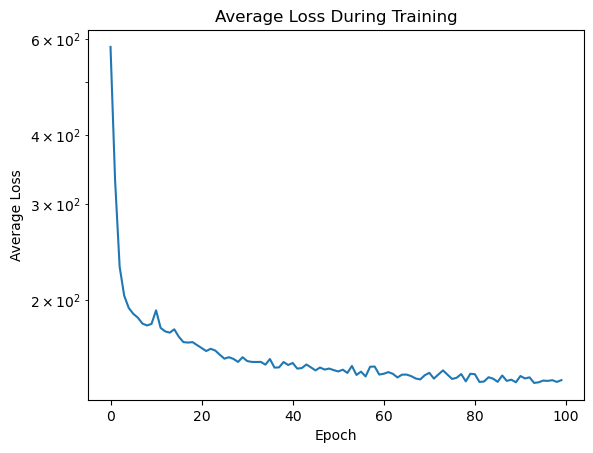

In [12]:
# ----- YOUR CODE HERE ----- #
Epoch = np.arange(0, len(avg_loss), 1)
plt.plot(Epoch, avg_loss)
plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss During Training")
plt.show()


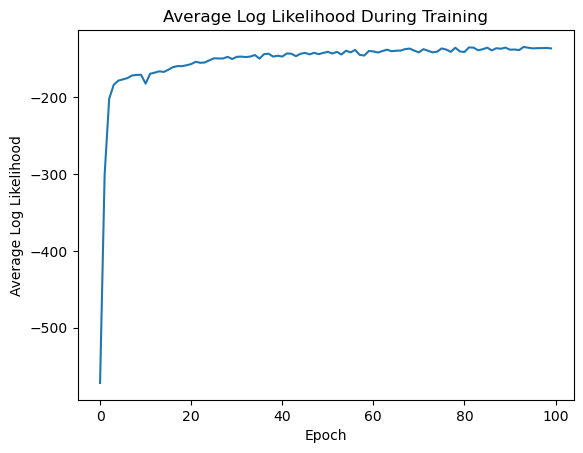

In [13]:
Epoch = np.arange(0, len(avg_log_likelihood), 1)
plt.plot(Epoch, avg_log_likelihood)
# plt.yscale('log')  # Set y-axis to log scale

plt.xlabel("Epoch")
plt.ylabel("Average Log Likelihood")
plt.title("Average Log Likelihood During Training")
plt.show()

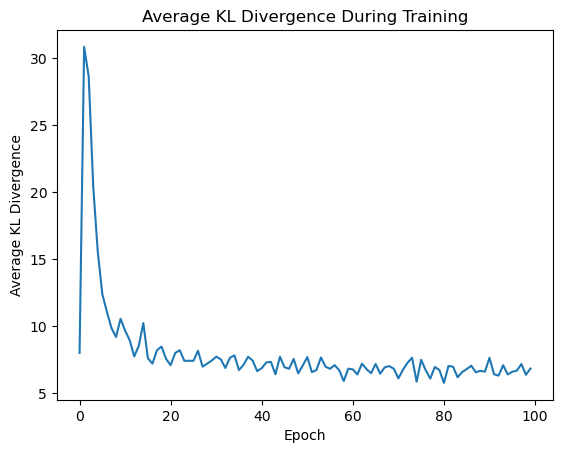

In [14]:
Epoch = np.arange(0, len(avg_kl_div), 1)
plt.plot(Epoch, avg_kl_div)
# plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epoch")
plt.ylabel("Average KL Divergence")
plt.title("Average KL Divergence During Training")
plt.show()

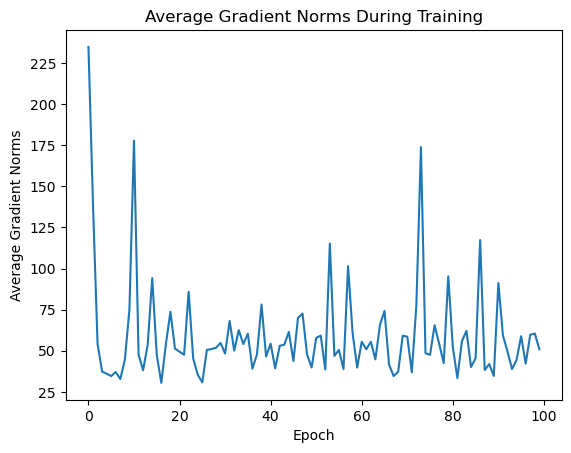

In [15]:
Epoch = np.arange(0, len(avg_grad_norms), 1)
plt.plot(Epoch, avg_grad_norms)
# plt.yscale('log')  # Set y-axis to log scale
plt.xlabel("Epoch")
plt.ylabel("Average Gradient Norms")
plt.title("Average Gradient Norms During Training")
plt.show()

### 1g: Visualizing VAE encodings

Visualize the encoded datapoints. Use the trained VAE's ```encode()``` function to get the means of the approximate posteriors.  If your VAE has a latent dimensionality (```hidden_size```) greater than 2 (we recommended 4 above), apply PCA to further reduce the dimensionality down to 2. Visualize these 2-dimensional embeddings on a scatter plot. Color each dot appropriately according to reaching angle (there should be a total of 728 dots).

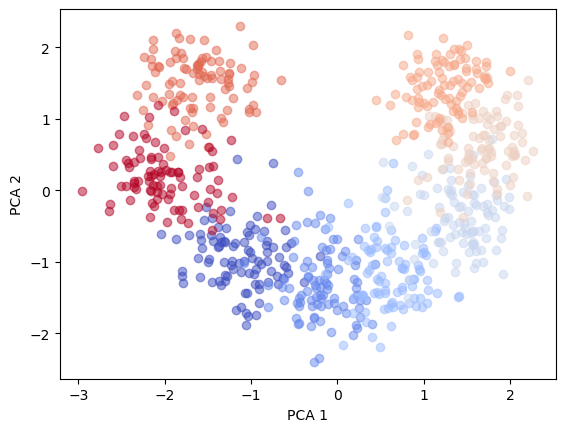

In [16]:
# ----- YOUR CODE HERE ----- #

mu, sigma = model.encode(torch.tensor(train_data))
mu = np.array(mu.detach())

mean = np.mean(mu, axis = 0)

centered = mu - mean

cov = np.cov(centered, rowvar= False)
real_evals, real_evecs = np.linalg.eig(cov)

sqrt_eval = np.sqrt(real_evals)

sorted_indices = np.argsort(sqrt_eval)

sorted_indices = np.argsort(sqrt_eval)[::-1]
sorted_eigenvecs = real_evecs[:, sorted_indices]
sqrt_eigvals = sqrt_eval[sorted_indices]

fig = plt.figure()
ax = fig.add_subplot(111)

colors = plt.cm.coolwarm(np.linspace(0, 1, num_class))
angle_idxs = np.arange(0, (728 + 91), 91)

for i in np.arange((len(angle_idxs)) - 1):
    start_idx = angle_idxs[i]
    end_idx = angle_idxs[i + 1]
    dot_data = centered[start_idx:end_idx]
    eig_vec = real_evecs[:, :2]

    data_3d = np.dot(dot_data, eig_vec)

    ax.scatter(data_3d[:, 0], data_3d[:, 1], alpha=0.5, c = [colors[i]], label=f'Reach Angle {i + 1}')

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

plt.show()

## 2. Building a Simple Classifier

Now, we would like to build a simple classifier to compare how it performs when trained on the raw data versus when trained on the low-dimensional embeddings encoded by your trained VAE. While it's typical for VAE model encoders to output both the mean and log standard deviation of the approximate posterior distribution, it is common to use the mean only as the encoded features for downstream tasks. We will only use the mean features to train the simple classifier.

Define a SimpleClassifier class (PyTorch ```nn.Module```) that is a (relatively) small neural network. One starting point would be two linear layers with a ReLU activation applied between the layers. Then, complete the training loop and evaluation code.

In [17]:
import torch.nn.functional as F

class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Implement a training loop for the classifier.

In [18]:
def train_classifier(model, dataloader, criterion, optimizer,
          num_epochs=100,
          disp_every=10):
    """
    Trains the classifier model.

    Parameters:
        model (nn.Module): The classifier model to be trained.
        dataloader (DataLoader): DataLoader object containing the training data.
        criterion (torch.nn.modules.loss._Loss): Loss function to be used.
        optimizer (torch.optim.Optimizer): Optimizer to be used for training.
        num_epochs (int): Number of training epochs (default is 1).
        disp_every (int): Interval for displaying training progress (default is 100).

    Returns:
        list: A list containing the training losses for each epoch.
    """
    epoch_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  
            running_loss += loss.item() * inputs.size(0)  

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_losses.append(epoch_loss)

        if (epoch + 1) % disp_every == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return epoch_losses

In [19]:
def evaluate_classifier(model, dataloader, criterion):
    """
    Evaluates the classifier model on the test data.

    Parameters:
        model (nn.Module): The trained classifier model to be evaluated.
        dataloader (DataLoader): DataLoader object containing the test data.
        criterion (torch.nn.modules.loss._Loss): Loss function to be used for evaluation.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item() * inputs.size(0)  
            _, predicted = torch.max(outputs, 1)  
            correct += (predicted == labels).sum().item()  
            total += labels.size(0)  

    average_loss = test_loss / total
    accuracy = correct / total
    print(f'Test Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')

    return average_loss, accuracy


## 3. Comparing Training Data

### 3a: Dataset preparation

First, we will need to set up the datasets and DataLoaders for the comparison between the raw data and encoded embeddings. You can reuse the provided ```SimpleDataset``` class for PyTorch Datasets.

To get the encoded embeddings, use the ```encode()``` function of your trained VAE. As a reminder, we will be using the mean only as the encoded features.

In [20]:
# Raw data datasets and DataLoaders
# ----- YOUR CODE HERE ----- #
raw_dataset = SimpleDataset(test_data, test_labels)
raw_loader = DataLoader(dataset, batch_size = 32, num_workers= 0)

In [21]:
# Encoded data datasets and DataLoaders
# ----- YOUR CODE HERE ----- #
encoded_dataset = SimpleDataset(mu, test_labels)
encoded_loader = DataLoader(dataset, batch_size = 32, num_workers= 0)

### 3b: Train a SimpleClassifier model using the raw data

Using the defined model from (2) and the datasets/DataLoaders created above, train an instance of the simple classifier using the raw data.

We recommend using cross entropy loss and the Adam optimizer, training for 1000 epochs. However, you may change any of the hyperparameters.

In [22]:
# ----- YOUR CODE HERE ----- #
model = SimpleClassifier(num_features, 64, num_class)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

raw_losses = train_classifier(model, raw_loader, criterion, optimizer)
raw_evaluations = evaluate_classifier(model, raw_loader, criterion)
raw_param_count = count_parameters(model)

Epoch [10/100], Loss: 0.6394
Epoch [20/100], Loss: 0.3204
Epoch [30/100], Loss: 0.2052
Epoch [40/100], Loss: 0.1492
Epoch [50/100], Loss: 0.1150
Epoch [60/100], Loss: 0.0920
Epoch [70/100], Loss: 0.0753
Epoch [80/100], Loss: 0.0628
Epoch [90/100], Loss: 0.0533
Epoch [100/100], Loss: 0.0459
Test Loss: 0.0521, Accuracy: 0.9904


Plot the training loss curve with epochs on the x-axis and loss on the y-axis.


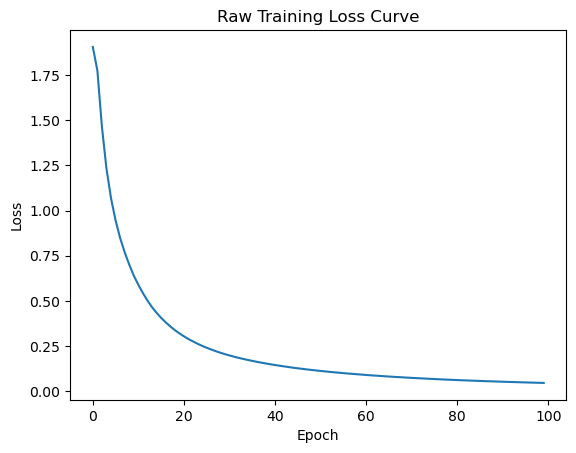

In [23]:
# ----- YOUR CODE HERE ----- #
Epoch = np.arange(0, len(raw_losses), 1)
plt.plot(Epoch, raw_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Raw Training Loss Curve")
plt.show()

### 3c: Train a SimpleClassifier model using the encoded data

Uisng the defined model from (2) and the datasets/DataLoaders created above, train an instance of the simple classifier using the encoded data.

We recommend using cross entropy loss and the Adam optimizer, training for 100 epochs. However, you may change any of the hyperparameters.


In [24]:
# ----- YOUR CODE HERE ----- #
model = SimpleClassifier(num_features, 64, num_class)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

encoded_losses = train_classifier(model, encoded_loader, criterion, optimizer)
encoded_evaluations = evaluate_classifier(model, encoded_loader, criterion)
encoded_param_count = count_parameters(model)

Epoch [10/100], Loss: 0.6307
Epoch [20/100], Loss: 0.3152
Epoch [30/100], Loss: 0.2026
Epoch [40/100], Loss: 0.1473
Epoch [50/100], Loss: 0.1134
Epoch [60/100], Loss: 0.0904
Epoch [70/100], Loss: 0.0740
Epoch [80/100], Loss: 0.0617
Epoch [90/100], Loss: 0.0523
Epoch [100/100], Loss: 0.0450
Test Loss: 0.0496, Accuracy: 0.9904


Plot the training loss curve with epochs on the x-axis and loss on the y-axis.

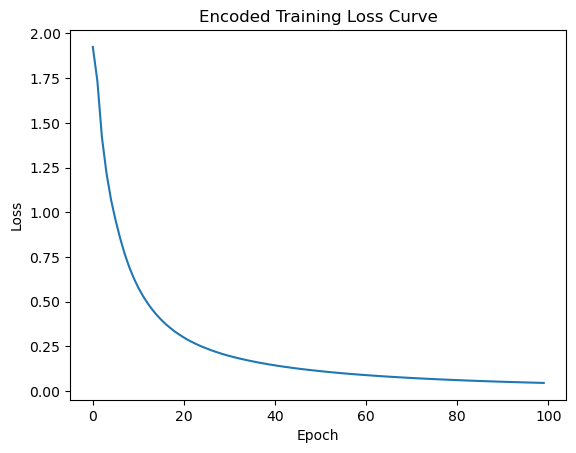

In [25]:
# ----- YOUR CODE HERE ----- #
# ----- YOUR CODE HERE ----- #
Epoch = np.arange(0, len(encoded_losses), 1)
plt.plot(Epoch, encoded_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Encoded Training Loss Curve")
plt.show()

### 3d: Evaluate and compare classifiers

Using your defined evaluation code, evaluate the two trained classifiers.

1. How many parameters do each of your trained models include?
2. Which of the models perform better? Why might this be the case?


In [26]:
# print("Raw Evaluations: ", raw_evaluations)
print(f'Raw Test Loss: {raw_evaluations[0]:.4f}, Raw Accuracy: {raw_evaluations[1]:.4f}')
print(f'Encoded Test Loss: {encoded_evaluations[0]:.4f}, Encoded Accuracy: {encoded_evaluations[1]:.4f}')

Raw Test Loss: 0.0521, Raw Accuracy: 0.9904
Encoded Test Loss: 0.0496, Encoded Accuracy: 0.9904


Your answers to the written questions here:

1. My VAE contains 9962 parameters, and the Simple Classifier contains 6792 parameters

2. My simple classifier outperforms the VAE, because in a classification task specifically, the supervised approach of the simple classifier lends itself to be better suited for specific classification tasks. However, I'm unsure as to how the number of parameters has a relationship on the accuracy of the model– intuitively, I would assume that having more parameters would lend to a higher acccuracy, but that does not always seem to be the case. 

## 4. Compare with a classifer from HW2

Now, try applying one of the classifiers you implemented from HW2, Question 4, to the encoded data.

1. How does training the classifier on top of the VAE compare to training it on just the raw data?

You may choose any of the classifier(s) from HW2, and may change the VAE hyperparameters above. Please list out any important hyperparameters or training details when comparing the classifier trained on top of the VAE to the classifier trained on just the raw data.

In [27]:
def poiss(data: np.array, num_class: int, num_trials: int, num_fea: int) -> tuple:
    """Calculate the parameters for the Poisson Model.

    Args:
        data: shape = (num_class, num_trials, num_fea)
        num_class: number of stimulus classes
        num_trials: number of trials
        num_fea: number of features
    Returns:
        pi (np.array): probability of being in a certain class, shape = (num_class)
        lda (np.array): the Poisson parameter of each class, shape = (num_class, num_fea,)
    """

    pi = np.zeros((num_class))
    lda = np.zeros((num_class, num_fea))
    
    for i in range(num_class):
        pi[i] = num_trials/(num_trials * num_class)
        lda[i] = np.sum(data[i], axis = 0) * 1/num_trials
    
    return pi, lda

def loglikelihood_poisson(arr: np.array, pi: np.array, lda: np.array) -> np.array:
    """Calculates the log-likelihood of a multivariate Poisson distribution.
    Args:
        arr: data points, shape = (num_data, num_fea)
        pi: shape = (num_fea,)
        lda: shape = (num_fea,)
    Returns:
        ll (np.array): loglikelihood of each data point, shape = (num_data,)
    """
    ll = np.zeros(arr.shape[0])
    for i, sample in enumerate(arr):
        dist = 0 
        for j, lda_i in zip(sample, lda):
            dist += j * np.log(lda_i) - lda_i
        ll[i] = np.log(pi) + ( dist)
    return ll

def decision_boundary_poisson(data: np.array, pi, lda) -> np.array:
    """
    Args:
        data: data points, shape = (num_data, num_fea)
    Returns:
        pred (np.array): prediction of which class each data point belongs to, shape = (num_data,)
    """
    # ----- YOUR CODE HERE ----- #
    num_classes, num_fea = lda.shape
    decisions = np.zeros((data.shape[0], num_classes))

    for k in range(num_classes):
        w_k = np.log(lda[k])
        w_k0 = np.log(pi[k]) - np.sum(lda[k])

        for j in range(num_classes):
            if k == j:
                continue
            w_j = np.log(lda[j])
            w_j0 = np.log(pi[j]) - np.sum(lda[j])

            decisions[:, k] += (w_k - w_j).T @ data.T + (w_k0 - w_j0)

    pred = np.argmax(decisions, axis=1)

    return pred

In [28]:
pi, lda = poiss(mu, num_class, num_train_trials, num_features)

In [29]:
vae_pi, vae_lda = poiss(mu, num_class, num_train_trials, 4)
vae_lda = np.abs(vae_lda)
vae_pred = decision_boundary_poisson(mu, vae_pi, vae_lda)

raw_pi, raw_lda = poiss(mu, num_class, num_train_trials, num_features)
raw_lda = np.abs(raw_lda)
raw_pred = decision_boundary_poisson(train_data, raw_pi, raw_lda)

In [30]:
vae_correct = 0
for i in range(len(test_data)):
  if vae_pred[i] == (i // num_test_trials):
    vae_correct += 1

vae_accuracy = vae_correct / len(test_data)  

raw_correct = 0
for i in range(len(test_data)):
  if raw_pred[i] == (i // num_test_trials):
    raw_correct += 1

raw_accuracy = raw_correct / len(test_data)  

print(f"Model on top of VAE accuracy: {vae_accuracy:.4f}") 

print(f"Model on raw data accuracy: {raw_accuracy:.4f}")

Model on top of VAE accuracy: 0.1799
Model on raw data accuracy: 0.1250


Your answers to the written question here:
1. How does training the classifier on top of the VAE compare to training it on just the raw data?

Training my classifier on top of the VAE resulted in a higher accuracy than just training it on raw data. This could be due to multiple factors:

    - VAEs can denoise through reconstructing the underlying patterns of the data while ignoring the noise. As we discussed in class, this results in cleaner and more accurate data representations. 
    - My VAE also reduces the dimensionality of the data through encoding it into a lower dimensional latent space. This reduces the complexity of the data and allows me the model to focus on the more relevant features.
    - The compacted representation of the data after passing it through the VAE can also help the Poisson model generalize better to the unseen data– we have relatively limited training data, so there is a high risk of overfitting. This helps with that. 
